In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import io
import os
import subprocess
import sys

import pandas as pd
from Bio import Entrez, Phylo, SearchIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pynucl.hist_features import hist_features, hist_shf4seq
from pytexshade import ipyshade, shade

In [5]:
def show_msa_jl(msa):
    """
    This requires jupyterlab-fasta extenstion and works only in jupyterlab
    """
    data = msa.format("fasta")
    bundle = {}
    bundle["application/vnd.fasta.fasta"] = data
    bundle["text/plain"] = data
    display(bundle, raw=True)

In [6]:
def muscle_aln(sequences, options=[], debug=False):
    muscle = os.path.join(os.path.dirname(sys.executable), "muscle")
    process = subprocess.Popen(
        [muscle] + options,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    aln, error = process.communicate(sequences.encode("utf-8"))
    if debug:
        print(sequences)
        print()
        print("Stderr:")
        print(error.decode("utf-8"))
        print("Stdout:")
        print(aln.decode("utf-8"))
    seqFile = io.StringIO()
    seqFile.write(aln.decode("utf-8"))
    seqFile.seek(0)
    sequences_ids = [s.split(" ", 1)[0] for s in sequences.split(">")]
    sequences = list(
        SeqIO.parse(seqFile, "fasta")
    )  # Not in same order, but does it matter?
    sequences.sort(key=lambda x: sequences_ids.index(x.id))  # Yes, it matters
    msa = MultipleSeqAlignment(sequences)
    return msa

In [7]:
def cons_features(msa):
    features_shf4seq = hist_shf4seq(
        SummaryInfo(msa).dumb_consensus(threshold=0.1, ambiguous="X")
    )
    features = []
    for f in features_shf4seq:
        f_new = f
        f_new["seqref"] = "consensus"
        features.append(f_new)
    return features

In [15]:
species = "Chimpanzee"

In [56]:
df = pd.read_csv(
    f"{species}_genes_vgnc.csv",
    dtype={
        "ncbi_id": "Int64",
    },
)
print(df.shape)
df.head()

(166, 19)


,index,vgnc_id,symbol,name,prev_symbol,prev_name,ncbi_id,ensembl_gene_id,uniprot_ids,Human gene ortholog HGNC ID,Species,taxon_id,accession,sequence,refseq_id,HGNC symbol,Clustered (canonical) isoform,Histone variant,Histone type
0,0,VGNC:14352,H1-0,H1.0 linker histone,H1F0,H1 histone family member 0,743278,ENSPTRG00000039392,A0A5S6RDJ7|K7CAI7,HGNC:4714,Chimpanzee,9598,XP_009436643.1,MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...,XP_009436643.1,H1-0,NaN,H1.0,H1
1,1,VGNC:14359,H1-1,"H1.1 linker histone, cluster member",HIST1H1A,histone cluster 1 H1 family member a,471874,ENSPTRG00000017796,A0A5S6RCZ2|H2QSF0,HGNC:4715,Chimpanzee,9598,XP_054541615.1,MSETVPPAPAASAAPEKPLAGKKAKKPAKAAAASKKKPAGPSVSEL...,XP_054541615.1,H1-1,NaN,H1.1,H1
2,2,VGNC:14242,H1-10,H1.10 linker histone,H1FX,H1 histone family member X,100608292,ENSPTRG00000015374,A0A5S6RB94|H2QNC1,HGNC:4722,Chimpanzee,9598,XP_003310048.1,MSVELEEALPVTTAEGMAKKVTKAGGSAALSPSKKRKNSKKKNQPG...,XP_003310048.1,H1-10,NaN,H1.10,H1
3,3,VGNC:14360,H1-2,"H1.2 linker histone, cluster member",HIST1H1C,histone cluster 1 H1 family member c,471878,ENSPTRG00000017804,A0A5S6RDQ5|H2QSF7,HGNC:4716,Chimpanzee,9598,XP_001172525.1,MSETAPAAPAAAPPAEKAPVKKKAAKKAGGTPRKASGPPVSELITK...,XP_001172525.1,H1-2,NaN,H1.2,H1
4,4,VGNC:14368,H1-3,"H1.3 linker histone, cluster member",HIST1H1D,histone cluster 1 H1 family member d,472227,ENSPTRG00000017819,H2QSG8,HGNC:4717,Chimpanzee,9598,XP_054541613.1,MSETAPVAPTTPAPAEKTPVKKKAKKAGATAGKRKASGPPVSELIT...,XP_054541613.1,H1-3,NaN,H1.3,H1


# H4C12

In [20]:
with Entrez.efetch(
    db="nuccore", id="NM_003534.3, NM_001374553.1", rettype="gb", retmode="text" # accession on H4C12 (NP_001361482.1 - protein)
) as handle:
    seq_records = list(SeqIO.parse(handle, "genbank"))
seq_records

[SeqRecord(seq=Seq('GGCTGAGTTTTTCTTTCAGGTAGTCTGAGATGGCCCGCACCAAGCAGACTGCAC...CTA', IUPACAmbiguousDNA()), id='NM_003534.3', name='NM_003534', description='Homo sapiens H3 clustered histone 8 (H3C8), mRNA', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTTTCTCTCGTTTGTGTTGAGTAGGTAGGTCTACTTAGCCATGGCACGAACAA...AAC', IUPACAmbiguousDNA()), id='NM_001374553.1', name='NM_001374553', description='Pan troglodytes H4 clustered histone 12 (H4C12), mRNA', dbxrefs=[])]

In [22]:
msa = muscle_aln("\n".join(list(map(lambda x: x.format("fasta"), seq_records))))
msa

<<class 'Bio.Align.MultipleSeqAlignment'> instance (2 records of length 515, SingleLetterAlphabet()) at 7f2818094240>

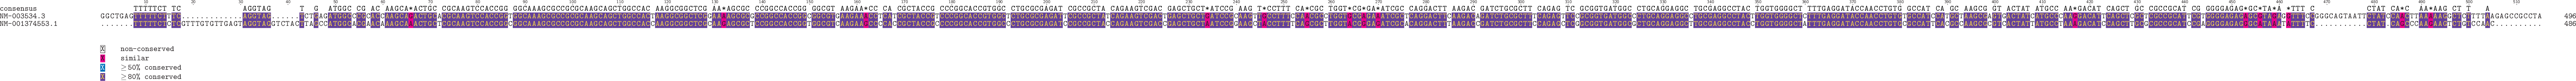

In [23]:
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

In [25]:
print(seq_records[0].seq.translate())
print(seq_records[1].seq.translate())

G*VFLSGSLRWPAPSRLHASPPVAKRRASSWPLRRLGKARRPPAA*RNLIATVPAPWLCARFAAIRSRLSC*SASCLSNAWCEKSLRTSRQICAFRVPR*WPCRRPARPTWWGSLRIPTCVPSMLSE*LSCPRTFSSLAAFVGRERRGFRAVILSNLKRLF*EPP
FFSRLC*VGRST*PWHEQSKLLASPPAAKRRASSWPPRRLARALRPPVASRSPTATAPAPWPCARSAATRSRPSC*SGSYLFSAWYGRSHRTLRPICASRARR*WRCRRLARPTWWGYLRIPTCAPFTPSASLLCLKTSSLRAASEGRGHKYFPISPRSLSN


In [27]:
translated_records = seq_records

'>NM_003534.3 Homo sapiens H3 clustered histone 8 (H3C8), mRNA\nGGCTGAGTTTTTCTTTCAGGTAGTCTGAGATGGCCCGCACCAAGCAGACTGCACGCAAGT\nCCACCGGTGGCAAAGCGCCGCGCAAGCAGCTGGCCACTAAGGCGGCTCGGAAAAGCGCGC\nCGGCCACCGGCGGCGTGAAGAAACCTCATCGCTACCGTCCCGGCACCGTGGCTCTGCGCG\nAGATTCGCCGCTATCAGAAGTCGACTGAGCTGCTGATCCGCAAGTTGCCTTTCCAACGCC\nTGGTGCGAGAAATCGCTCAGGACTTCAAGACAGATCTGCGCTTTCAGAGTTCCGCGGTGA\nTGGCCCTGCAGGAGGCCTGCGAGGCCTACTTGGTGGGGCTCTTTGAGGATACCAACCTGT\nGTGCCATCCATGCTAAGCGAGTGACTATCATGCCCAAGGACATTCAGCTCGCTCGCCGCA\nTTCGTGGGGAGAGAGCGTAGAGGTTTCCGGGCAGTAATTCTATCCAACTTAAAAAGGCTC\nTTTTAAGAGCCGCCTA\n'

In [40]:
translated_sequences = "\n".join(
    [
        SeqRecord(
            sr.seq.translate(),
            id=sr.id,
            name=sr.name,
            description=sr.description,
        ).format("fasta")
        for sr in seq_records
    ]
)
msa_translated = muscle_aln(translated_sequences)

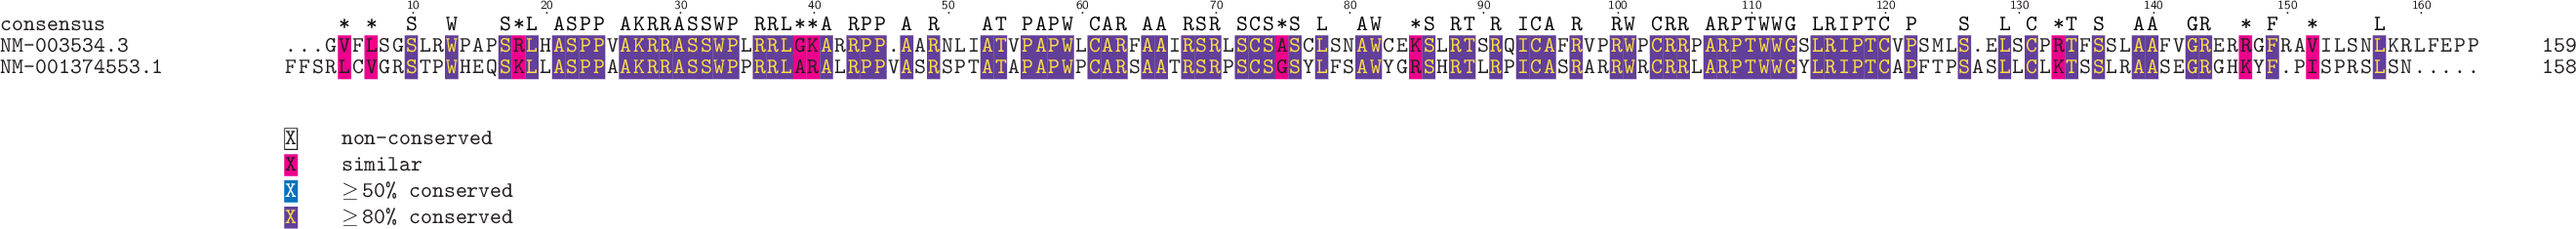

In [41]:
ipyshade.shadedmsa(
    msa_translated,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C1

In [45]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H3C1", "H3C8"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [50]:
print(sequences)

>XP_054541616.1|H3C1 H3C1|XP_054541616.1
MGVFALVLGIPLCCFAVMARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYR
PGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVG
LFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>XP_016810514.1|H3C8 H3C8|XP_016810514.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA



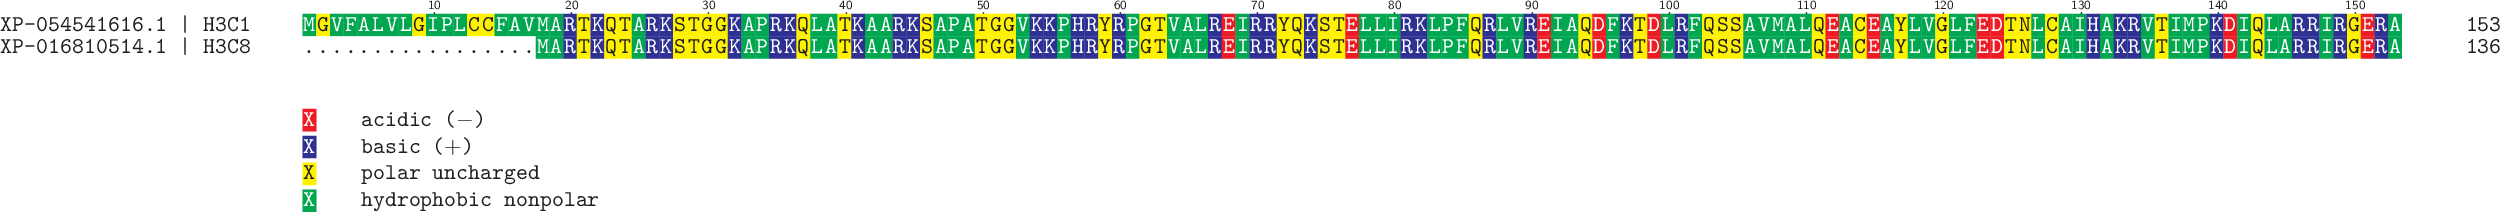

In [48]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["hydropathy_functional"],
    ruler=True,
    # logo=True,
)

# H2AC15

In [51]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC11", "H2AC15"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [52]:
print(sequences)

>XP_063668326.1|H2AC11 H2AC11|XP_063668326.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_054542624.1|H2AC15 H2AC15|XP_054542624.1
MSGRGKQGGKARTKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



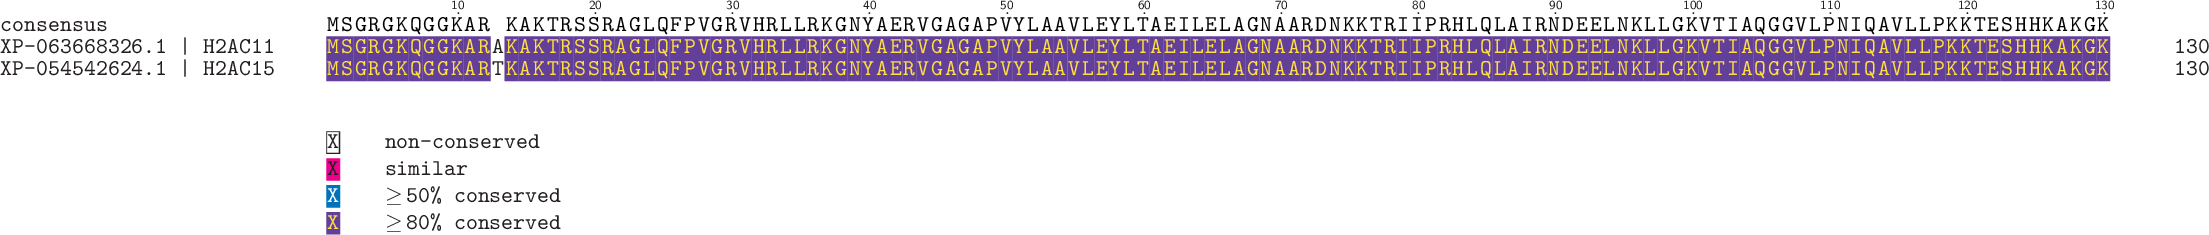

In [54]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# clustered H4

In [65]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[(df["Histone variant"] == "clustered H4") & (~df["sequence"].isna())].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [63]:
print(sequences)

>XP_009428446.1|H4C1|isoform_1 H4C1|XP_009428446.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_009448973.3|H4C11|isoform_1 H4C11|XP_009448973.3
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>PNI76180.1|H4C13|isoform_1 H4C13|PNI76180.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYG

>XP_063653741.1|H4C14|isoform_1 H4C14|XP_063653741.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_063653739.1|H4C14|isoform_1 H4C14|XP_063653739.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_003308403.1|H4C14|isoform_1 H4C14|XP_003308403.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_063653754.1|H4C15|isoform_1 H4C15|XP_063653754.1
MSGRGK

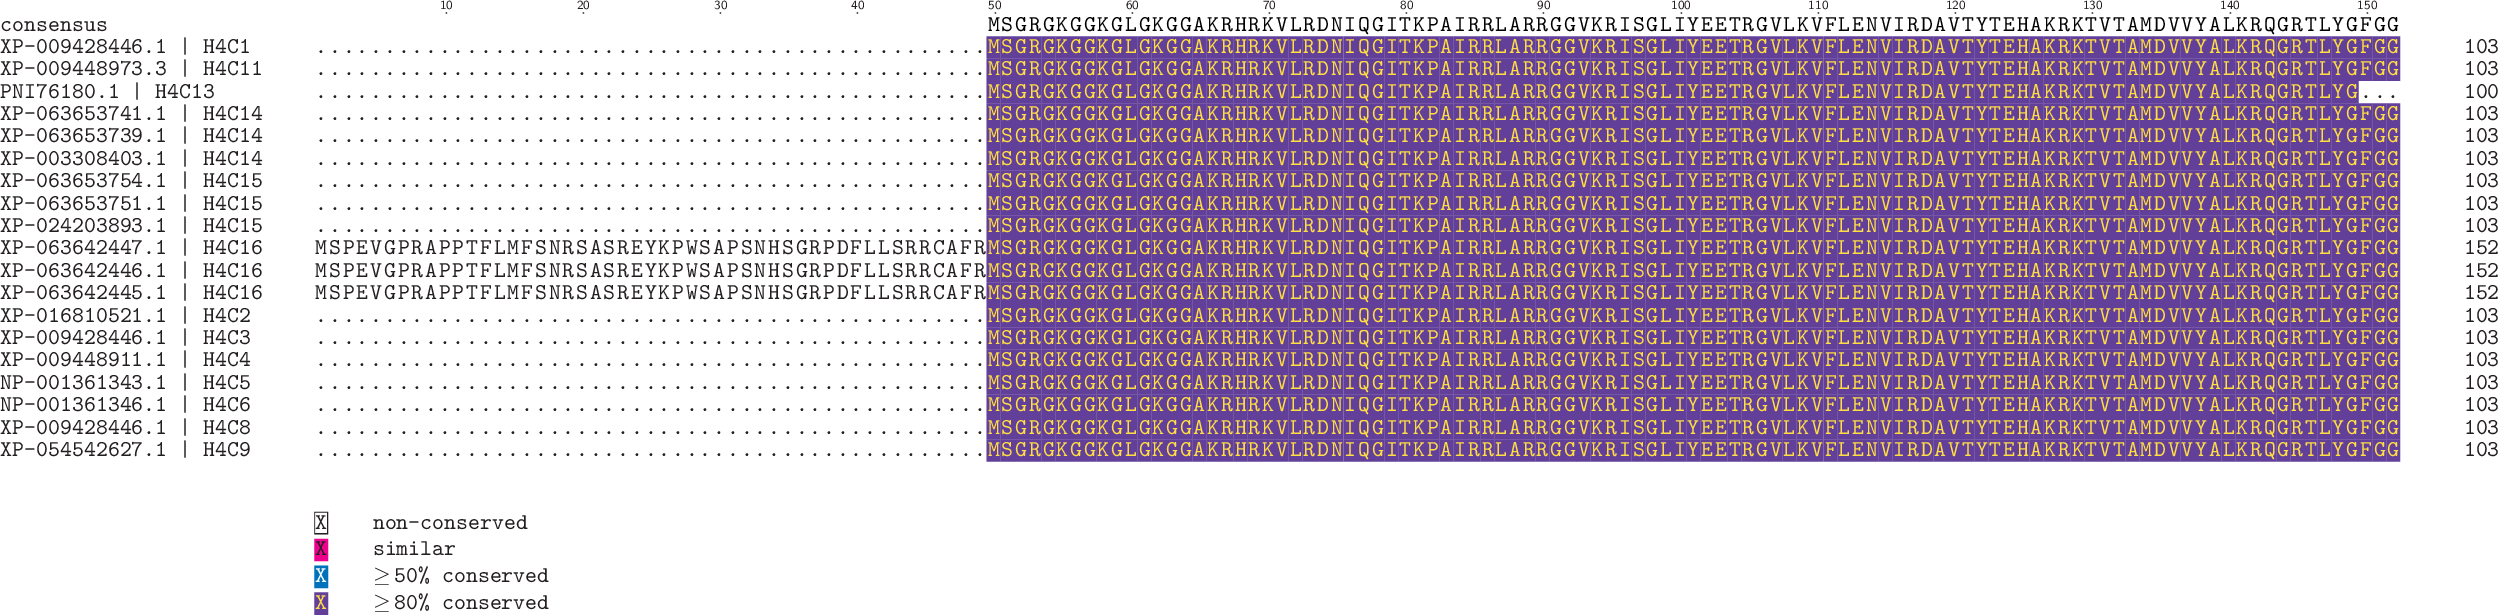

In [66]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

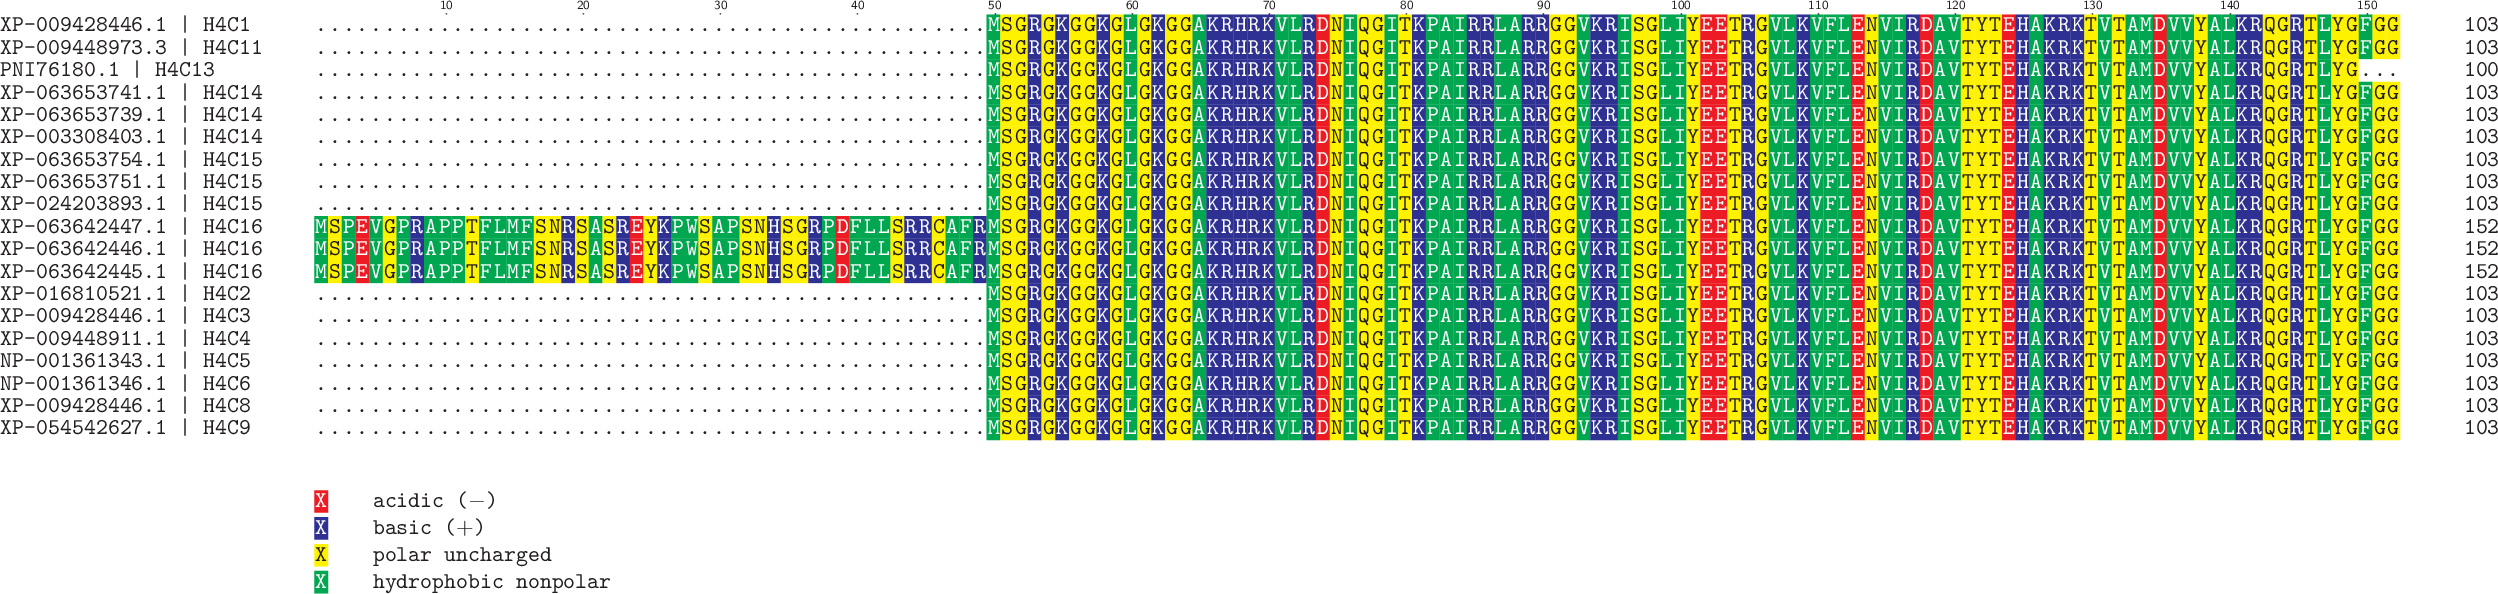

In [67]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["hydropathy_functional"],
    ruler=True,
    # logo=True,
)